<a href="https://colab.research.google.com/github/srak71/Image-To-Asyptote-Tuning/blob/main/baseline_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns # For a nicer confusion matrix plot

# For progress bar
#!pip install tqdm -q
#from tqdm.notebook import tqdm

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Device Name: Tesla T4


In [ ]:
# Cell 2
# --- Configuration ---
BASE_DIR = "/content/drive/MyDrive/StarSparkProj" # Your project's base directory on Drive

# Using the pre-split validation metadata for baseline testing
METADATA_FILE = os.path.join(BASE_DIR, "val_metadata_Full.csv")

# Path to the saved untrained model weights
UNTRAINED_MODEL_WEIGHTS_PATH = os.path.join(BASE_DIR, "untrained_resnet50_initial_weights.pth")

# Model & Training Parameters
NUM_EPOCHS = 1
BATCH_SIZE = 32
LEARNING_RATE = 0.001
IMAGE_SIZE = 224

# Determine device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# NUM_CLASSES and label mapping will be determined from the data in a later cell.

# --- Helper Function for plotting training results (if training is done later) ---
def plot_training_results(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    if 'train_acc' in history and 'val_acc' in history:
        axs[0].plot(history['train_acc'], label='Train Accuracy')
        axs[0].plot(history['val_acc'], label='Validation Accuracy')
        axs[0].set_title('Accuracy over Epochs')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].legend()
        axs[0].grid(True)

    if 'train_loss' in history and 'val_loss' in history:
        axs[1].plot(history['train_loss'], label='Train Loss')
        axs[1].plot(history['val_loss'], label='Validation Loss')
        axs[1].set_title('Loss over Epochs')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
        axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# --- Helper function for plotting confusion matrix ---
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Using device: cuda


In [ ]:
# Cell 3 (Revised for clearer, instance-based error reporting)
class AsymptoteDataset(Dataset):
    def __init__(self, metadata_df, transform=None, label_encoder=None):
        self.metadata_df = metadata_df.copy() # Use a copy
        self.transform = transform
        self.label_encoder = label_encoder
        self._missing_files_reported_this_worker = 0 # Renamed for clarity
        self._max_missing_file_warnings_per_worker = 5

        if self.label_encoder is None:
            self.label_encoder = LabelEncoder()
            if 'function_type' in self.metadata_df.columns:
                self.metadata_df['function_type_encoded'] = self.label_encoder.fit_transform(self.metadata_df['function_type'])
            else:
                self.metadata_df['function_type_encoded'] = pd.Series(dtype='int')
        else: # Encoder is pre-fitted
            if 'function_type' in self.metadata_df.columns:
                known_labels_mask = self.metadata_df['function_type'].isin(self.label_encoder.classes_)
                if not known_labels_mask.all():
                    unknown_labels = self.metadata_df.loc[~known_labels_mask, 'function_type'].unique()
                    print(f"Dataset Note: Found unknown labels {list(unknown_labels)} not in pre-fitted LabelEncoder. These will be handled as 'missing/invalid'.")
                    self.metadata_df.loc[~known_labels_mask, 'function_type_encoded'] = -1 # Assign -1 for unknown
                    if known_labels_mask.any():
                         self.metadata_df.loc[known_labels_mask, 'function_type_encoded'] = self.label_encoder.transform(self.metadata_df.loc[known_labels_mask, 'function_type'])
                else:
                    self.metadata_df['function_type_encoded'] = self.label_encoder.transform(self.metadata_df['function_type'])
            else:
                 self.metadata_df['function_type_encoded'] = pd.Series(dtype='int')

        self.classes = self.label_encoder.classes_ if hasattr(self.label_encoder, 'classes_') else []

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        if idx >= len(self.metadata_df):
            raise IndexError("Index out of bounds in AsymptoteDataset")

        img_path = self.metadata_df.iloc[idx]['image_path']

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            self._missing_files_reported_this_worker += 1
            if self._missing_files_reported_this_worker <= self._max_missing_file_warnings_per_worker:
                print(f"Dataset Note (Worker PID {os.getpid()}, Missing file {self._missing_files_reported_this_worker}/{self._max_missing_file_warnings_per_worker}): Image not found: {img_path}. Placeholder used.")
            elif self._missing_files_reported_this_worker == self._max_missing_file_warnings_per_worker + 1:
                print(f"Dataset Note (Worker PID {os.getpid()}): Further 'Image not found' messages from this worker will be suppressed. Total missing so far for this worker: {self._missing_files_reported_this_worker}")
            return torch.zeros((3, IMAGE_SIZE, IMAGE_SIZE)), torch.tensor(-1, dtype=torch.long)
        except Exception as e:
            # For other image loading errors, still return a placeholder
            self._missing_files_reported_this_worker += 1
            if self._missing_files_reported_this_worker <= self._max_missing_file_warnings_per_worker:
                 print(f"Dataset Note (Worker PID {os.getpid()}, Load error {self._missing_files_reported_this_worker}/{self._max_missing_file_warnings_per_worker}): Error loading {img_path}: {e}. Placeholder used.")
            elif self._missing_files_reported_this_worker == self._max_missing_file_warnings_per_worker + 1:
                 print(f"Dataset Note (Worker PID {os.getpid()}): Further load error messages from this worker will be suppressed. Total issues for this worker: {self._missing_files_reported_this_worker}")
            return torch.zeros((3, IMAGE_SIZE, IMAGE_SIZE)), torch.tensor(-1, dtype=torch.long)

        label_val_series = self.metadata_df.iloc[idx]
        if 'function_type_encoded' in label_val_series:
            label_val = label_val_series['function_type_encoded']
            if pd.isna(label_val):
                label_val = -1 # If NaN somehow got into encoded column
        else: # Should not happen if DataFrame is structured correctly
            label_val = -1
            print(f"Dataset Warning: 'function_type_encoded' column missing for index {idx}. Using -1.")


        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(int(label_val), dtype=torch.long)

# Define transformations (no change)
data_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("AsymptoteDataset class (revised for clearer, per-worker error reporting) and data_transforms defined.")

AsymptoteDataset class (revised for clearer, per-worker error reporting) and data_transforms defined.


In [ ]:
# Cell 4
# Load validation metadata
try:
    val_metadata_df_original = pd.read_csv(METADATA_FILE)
    print(f"Loaded validation metadata from: {METADATA_FILE} with {len(val_metadata_df_original)} records.")

    if val_metadata_df_original.empty:
        raise ValueError("Validation metadata file is empty after loading.")
    if 'function_type' not in val_metadata_df_original.columns:
        raise ValueError("'function_type' column not found in metadata.")
    if val_metadata_df_original['function_type'].isnull().any():
        print(f"Warning: Found {val_metadata_df_original['function_type'].isnull().sum()} NaN values in 'function_type' column. Records with NaN will be dropped for label encoding and dataset creation.")
        val_metadata_df = val_metadata_df_original.dropna(subset=['function_type']).copy()
        if val_metadata_df.empty:
            raise ValueError("Metadata became empty after dropping NaN function types.")
    else:
        val_metadata_df = val_metadata_df_original.copy()

except FileNotFoundError:
    print(f"ERROR: Validation metadata file not found at {METADATA_FILE}")
    val_metadata_df = pd.DataFrame()
except ValueError as e:
    print(f"ERROR: {e}")
    val_metadata_df = pd.DataFrame()
except Exception as e:
    print(f"An unexpected error occurred while loading metadata: {e}")
    val_metadata_df = pd.DataFrame()


if not val_metadata_df.empty:
    global_label_encoder = LabelEncoder()
    global_label_encoder.fit(val_metadata_df['function_type'])
    FUNCTION_TYPES_ORDERED = global_label_encoder.classes_
    NUM_CLASSES = len(FUNCTION_TYPES_ORDERED)
    print(f"Identified {NUM_CLASSES} classes: {list(FUNCTION_TYPES_ORDERED)}")

    val_dataset = AsymptoteDataset(val_metadata_df,
                                   transform=data_transforms,
                                   label_encoder=global_label_encoder)

    # >>> MODIFICATION SUGGESTION for cleaner warning output <<<
    # Set num_workers=0 to use a single process for data loading.
    # This will make the "Dataset Note (Worker PID...)" messages sequential and less confusing.
    # For actual training, you'd likely want num_workers=2 or higher for speed.
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) # Changed from 2 to 0
    print(f"Validation DataLoader prepared with {len(val_loader.dataset)} samples. (Using num_workers=0 for clearer console output during baseline test)")

else:
    print("Validation metadata is empty or could not be processed. Cannot proceed.")
    NUM_CLASSES = 0
    FUNCTION_TYPES_ORDERED = []
    val_loader = None
    global_label_encoder = None

Loaded validation metadata from: /content/drive/MyDrive/StarSparkProj/val_metadata_Full.csv with 1000 records.
Identified 6 classes: ['circle', 'ellipse', 'hyperbola', 'linear', 'quadratic', 'sine']
Validation DataLoader prepared with 1000 samples. (Using num_workers=0 for clearer console output during baseline test)


In [ ]:
# Cell 5
# Instantiate a ResNet50 model structure (randomly initialized at first)
# Use the same method as in load_model.ipynb to ensure structural consistency
try:
    model = models.resnet50(weights=None)
    print("Instantiated ResNet50 structure with `weights=None`.")
except TypeError:
    model = models.resnet50(pretrained=False)
    print("Instantiated ResNet50 structure with `pretrained=False`.")

# Load the saved 'untrained' weights
if os.path.exists(UNTRAINED_MODEL_WEIGHTS_PATH):
    try:
        model.load_state_dict(torch.load(UNTRAINED_MODEL_WEIGHTS_PATH, map_location=DEVICE))
        print(f"Successfully loaded untrained weights from: {UNTRAINED_MODEL_WEIGHTS_PATH}")
    except Exception as e:
        print(f"Error loading saved weights: {e}. The model will proceed with fresh random initialization.")
else:
    print(f"Warning: Untrained weights file not found at {UNTRAINED_MODEL_WEIGHTS_PATH}. "
          "The model will proceed with its default fresh random initialization.")

# Modify the final fully connected layer for *your specific dataset's* number of classes
# This NUM_CLASSES comes from Cell 4 after loading your actual data.
if NUM_CLASSES > 0:
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    print(f"ResNet50's final layer adapted for {NUM_CLASSES} classes.")
else:
    print("Warning: NUM_CLASSES is not defined (possibly due to data loading issues). Cannot adapt model.fc.")


# Move the model to the specified device
model = model.to(DEVICE)

print(f"Model prepared and loaded on {DEVICE}.")

Instantiated ResNet50 structure with `weights=None`.
Successfully loaded untrained weights from: /content/drive/MyDrive/StarSparkProj/untrained_resnet50_initial_weights.pth
ResNet50's final layer adapted for 6 classes.
Model prepared and loaded on cuda.


In [ ]:
# Cell 6 (Revised to report skipped samples more clearly)
def evaluate_model(model, dataloader, device, num_classes, class_names_from_encoder):
    model.eval()
    all_preds = []
    all_labels = []
    total_samples_in_dataloader = len(dataloader.dataset)
    valid_samples_processed_count = 0

    if dataloader is None:
        print("Error: Dataloader is None. Cannot evaluate.")
        return 0, "Evaluation skipped: Dataloader is None.", None, 0

    # Reset missing files counter in dataset instance if it exists (for multiple calls)
    if hasattr(dataloader.dataset, '_missing_files_count') and hasattr(dataloader.dataset, '_max_missing_file_warnings'):
        dataloader.dataset._missing_files_count = 0


    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            # Filter out samples with label -1 (indicating a loading error)
            valid_mask = labels != -1

            inputs = inputs[valid_mask]
            labels = labels[valid_mask]

            if inputs.nelement() == 0: # If batch becomes empty after filtering
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            valid_samples_processed_count += len(labels)

    print(f"\n--- Evaluation Summary ---")
    print(f"Total samples in validation metadata: {total_samples_in_dataloader}")

    dataset_level_missing_files = 0
    if hasattr(dataloader.dataset, 'get_missing_files_count'):
        dataset_level_missing_files = dataloader.dataset.get_missing_files_count()
        if dataset_level_missing_files > 0:
             print(f"Dataset reported {dataset_level_missing_files} image(s) could not be loaded.")

    print(f"Successfully processed and evaluated {valid_samples_processed_count} valid samples.")
    if total_samples_in_dataloader - valid_samples_processed_count > 0:
        print(f"Skipped {total_samples_in_dataloader - valid_samples_processed_count} samples due to loading issues or invalid labels.")

    if valid_samples_processed_count == 0:
        print("No valid samples were processed. Cannot generate report or confusion matrix.")
        return 0, "No valid data for report.", None, 0

    accuracy = accuracy_score(all_labels, all_preds)

    # Use the class names derived from the fitted label_encoder
    report_class_names = list(class_names_from_encoder)
    report_labels_indices = list(range(len(report_class_names)))

    cm = confusion_matrix(all_labels, all_preds, labels=report_labels_indices)
    class_report = classification_report(all_labels, all_preds,
                                         target_names=report_class_names,
                                         labels=report_labels_indices,
                                         zero_division=0)

    print(f"\nAccuracy (on {valid_samples_processed_count} valid samples): {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)

    if valid_samples_processed_count > 0 :
        plot_confusion_matrix(cm, report_class_names)

    return accuracy, class_report, cm, valid_samples_processed_count

print("Evaluation function (revised for clearer reporting) defined.")

Evaluation function (revised for clearer reporting) defined.


--- Evaluating Untrained ResNet50 Model (from saved initial weights) ---


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Dataset Note (Worker PID 754, Missing file 1/5): Image not found: /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-1.15_i-2.94.png. Placeholder used.
Dataset Note (Worker PID 754, Missing file 2/5): Image not found: /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-2.96_i2.22.png. Placeholder used.
Dataset Note (Worker PID 754, Missing file 3/5): Image not found: /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s-0.8_i-4.67.png. Placeholder used.
Dataset Note (Worker PID 754, Missing file 4/5): Image not found: /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s0.47_i-1.38.png. Placeholder used.
Dataset Note (Worker PID 754, Missing file 5/5): Image not found: /content/drive/MyDrive/StarSparkProj/AsymptoteDataset_Full/linear_s2.95_i2.16.png. Placeholder used.
Dataset Note (Worker PID 754): Further 'Image not found' messages from this worker will be suppressed. Total missing so far for this worker: 6

--- Evaluation S

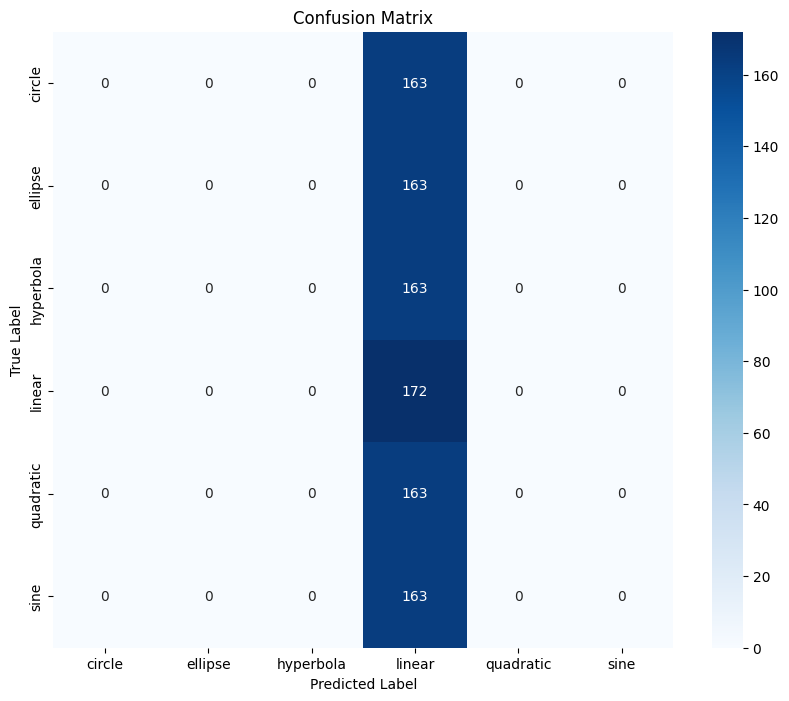


For reference, random guessing accuracy for 6 classes would be around: 0.1667


In [ ]:
# Cell 7
if not val_metadata_df.empty and val_loader is not None and 'model' in locals() and global_label_encoder is not None:
    print("--- Evaluating Untrained ResNet50 Model (from saved initial weights) ---")

    # Ensure model, NUM_CLASSES and FUNCTION_TYPES_ORDERED are correctly defined
    if NUM_CLASSES > 0 and FUNCTION_TYPES_ORDERED is not None and len(FUNCTION_TYPES_ORDERED) == NUM_CLASSES:
        baseline_accuracy, baseline_report, baseline_cm, num_evaluated = evaluate_model(
            model,
            val_loader,
            DEVICE,
            num_classes=NUM_CLASSES,
            class_names_from_encoder=global_label_encoder.classes_ # Pass encoder's classes directly
        )

        if NUM_CLASSES > 0 and num_evaluated > 0: # Only print if evaluation happened
            expected_random_accuracy = 1.0 / NUM_CLASSES
            print(f"\nFor reference, random guessing accuracy for {NUM_CLASSES} classes would be around: {expected_random_accuracy:.4f}")
    else:
        print("Model, NUM_CLASSES, or FUNCTION_TYPES_ORDERED not properly initialized. Skipping evaluation.")
        if NUM_CLASSES <= 0: print(f"Debug: NUM_CLASSES is {NUM_CLASSES}")
        if FUNCTION_TYPES_ORDERED is None: print(f"Debug: FUNCTION_TYPES_ORDERED is None")
        elif len(FUNCTION_TYPES_ORDERED) != NUM_CLASSES: print(f"Debug: Mismatch len(FUNCTION_TYPES_ORDERED)={len(FUNCTION_TYPES_ORDERED)} vs NUM_CLASSES={NUM_CLASSES}")

else:
    print("Skipping baseline evaluation: Validation data/loader is not available or model/label encoder not initialized.")